### This notebook creates 4 CSV files with $n$ rows and  $(h * w) + 1$ columns each, where $n$ is the number of pictures per image set and $h$ and $w$ are height and width of a picture. The first $h * w$ cells of the $n$th row contain the mean of the RGB value of a pixel of the $n$th picture of the respective image set. The last column contains the labels of the respective images.

In [106]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc
from PIL import Image

WIDTH, HEIGHT = 124, 124
DATA_DIR = os.path.join("..", "data")
UNHEALTHY_DIR = '/mnt/naruto/mina_workspace/Brain_5Classes/Data/HT/'
HEALTHY_LIST_FILE = 'subset-3-HnzTnx.txt'
OUTPUT_CSV = 'scull_set.txt.csv'

In [62]:
def get_images(directory):
    imagefiles = (os.path.join(directory, f) for f in os.listdir(directory))
    imagefiles = (f for f in imagefiles if os.path.isfile(f))
    imagefiles = ((f, 1) for f in imagefiles if f[-4:] == ".png")
    return imagefiles

def get_unhealthy_paths():
    return get_images(UNHEALTHY_DIR)

def get_healthy_paths():
    csv_file = os.path.join(DATA_DIR, HEALTHY_LIST_FILE)
    with open(csv_file) as f:
        data_file = f.read().splitlines()
    # Split in paths and labels
    imagefiles = (entry.split(' ') for entry in data_file)
    imagefiles = ((x[0], int(x[1])) for x in imagefiles if len(x) == 2)
    # Get only healthy images
    imagefiles = (x for x in imagefiles if x[1] == 0)
    # Sanitize paths
    imagefiles = ((x[0].replace('Train/', 'Train/Train/'), x[1]) for x in imagefiles)
    return imagefiles

In [63]:
healthy_set = list(get_healthy_paths())
unhealthy_set = list(get_unhealthy_paths())
for p, l in healthy_set:
    assert os.path.isfile(p)
    assert l == 0
for p, l in unhealthy_set:
    assert os.path.isfile(p)
    assert l == 1
print('{} healthy images'.format(len(healthy_set)))
print('{} unhealthy images'.format(len(unhealthy_set)))

2213 healthy images
92960 unhealthy images


In [194]:
def get_all_images():
    healthy_set = list(get_healthy_paths())
    unhealthy_set = list(get_unhealthy_paths())[:len(healthy_set)]
    return healthy_set + unhealthy_set

def convert_rgba_to_rgb(path):
    png = Image.open(path)
    png.load() # required for png.split()
    if len(png.split()) > 3:
        background = Image.new("RGB", png.size, (255, 255, 255))
        background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
        png = background
    return png

def png_to_matrix(path):
    # Convert image to matrix
    img = np.array(convert_rgba_to_rgb(path))
    if len(img.shape) == 3:
        # Turn RGB into grayscaled image
        img = np.mean(img, axis=2)
    # Fix the first line of each healthy image (which already have the correct size)
    if img.shape == (WIDTH, HEIGHT):
        # Before there was a white row: 255
        img[0] = 0
        # Healthy images are previously rotated by -90°
        img = np.rot90(img)
        # Last row contains almost black values: 3
        img[-1, img[-1] == 3] = 0
    else:
        # Resize unhealthy images to match the healthy ones
        img = scipy.misc.imresize(img, (WIDTH, HEIGHT))
    return img.astype(np.uint8)

def show_image(path):
    print(path)
    img = png_to_matrix(path)
    print("Image matrix shape:", img.shape)
    plt.imshow(img, cmap='gray')
    plt.show()

def prepare_output_file(file):
    columns = [str(x) for x in range(WIDTH * HEIGHT)] + ['label']
    df = pd.DataFrame([], columns=columns, dtype=np.uint8)
    df.to_csv(file, index=False)
    
def convert_images_to_csv():
    csv_output = os.path.join(DATA_DIR, OUTPUT_CSV)
    prepare_output_file(csv_output)
    image_paths, labels = zip(*get_all_images())
    # Test png_to_matrix with first (healthy) and last (unhealthy) picture
    show_image(image_paths[0])
    show_image(image_paths[-1])
    # Build dataframe with X and y
    print('Preprocessing', end='')
    content = ''
    for i, path, y in zip(range(len(labels)), image_paths, labels):
        try:
            img = png_to_matrix(path).reshape([-1])
            content += ','.join([str(x) for x in img]) + ',{}\n'.format(y)
            if (i % 500 == 0 and i != 0) or i == len(labels) - 1:
                # Only open stream after a few hundred steps due to performance
                with open(csv_output, 'a') as f:
                    f.write(content)
                content = ''
                print('.', end='')
        except Exception as e:
            img_id = '.'.join(path.split('/')[-1].split('.')[:-1])
            print(img_id + ': ' + str(e))
            print('Failed')
            return -1
    print('Done')
    return csv_output

/mnt/naruto/mina_workspace/Brain_5Classes/Data/Train/Train/IXI002-Guys-0828-T1.nii.nz100.png
Image matrix shape: (124, 124)


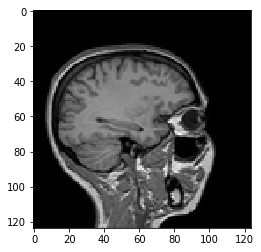

/mnt/naruto/mina_workspace/Brain_5Classes/Data/HT/IXI038-Guys-0729-T1.nii.nz.94_Flair_218.nx.130_.png
Image matrix shape: (124, 124)


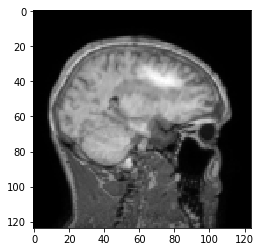

Preprocessing.........Done


In [195]:
output_file = convert_images_to_csv()

In [196]:
pd.read_csv(os.path.join(DATA_DIR, OUTPUT_CSV), index_col=False)

,0,1,2,3,4,5,6,7,8,9,...,15367,15368,15369,15370,15371,15372,15373,15374,15375,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
